# Multiclass classification with CNN and pre-trained word embeddings

#### Aaron Anderson

This notebook presents a working example of a classification problem using a convolutional neural network architecture that exploits pre-trained word embeddings from Google's word2vec.

---
### 1. Imports

In [2]:
import numpy as np
import pandas as pd
import string
import os
import csv
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization, Flatten
from sklearn.naive_bayes import GaussianNB
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.keyedvectors import KeyedVectors

Using TensorFlow backend.


---
### 2. Load labeled data

In [3]:
df = pd.read_csv('labeled_data.csv')
df = df.dropna(subset = ['sentiment ', 'text'])
display(df.head())
print(f'The data has {df.shape[0]} rows.')

/Users/ama/NWRC/Venv/cnn-nlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1,2,10,11,18,22,23,25,26,28,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Identity,topics,sentiment,created_at,text,user_loc,user_desc,coords,geo,place,...,user_lang,user_following,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,source_file
0,conservative,control,-1,Sat Jun 01 03:59:44 +0000 2019,(Agricultural) DIVERSITY is OUR STRENGTH... #t...,"Ottawa, Ontario",11th Gen. Cdn. (1653) Conservative. Retired sm...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_feralswine_05012019to11042019.csv
1,She,concern,0,Tue Aug 06 17:39:49 +0000 2019,People posted the O RLY owl for like three yea...,Ebou Dar,She/Her ~ Somewhere on the ace/aro spectrum ~ ...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildpigs_05012019to11042019.csv
2,Student,info,0,Tue Aug 06 07:31:55 +0000 2019,I fight back the tears at my children's funera...,"Tucson, AZ",Like all of my tweets are going to be video g...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildpigs_05012019to11042019.csv
3,Farmer,concern,-1,Sun May 26 20:59:04 +0000 2019,Feral swine amassed at Montana‚Äôs northern bo...,New York State,"Female dairy farmer (4th generation), assistan...",NaN,NaN,NaN,...,NaN,NaN,NaN,False,11,21,False,False,en,results_feralswine_05012019to11042019.csv
4,"Reporter, Military",concern,-1,Wed Aug 07 18:19:35 +0000 2019,What a sentence by @AlexHortonTX: Millions of ...,Washington,Reporter @washingtonpost. Formerly at @starsan...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildhogs_05012019to11042019.csv


The data has 926 rows.


In [3]:
category = np.array(df['sentiment '])
texts = np.array(df['text'])

In [4]:
print(f"Fraction negative = {round(np.sum(category == '-1') / df.shape[0], 2)}")
print(f"Fraction neutral = {round(np.sum(category == '0') / df.shape[0], 2)}")
print(f"Fraction positive = {round(np.sum(category == '1') / df.shape[0], 2)}")

Fraction negative = 0.43
Fraction neutral = 0.43
Fraction positive = 0.14


---
### 3. Functions for data organization

In [5]:
def split_sample(category, texts, val_start, val_end):
    """ Splits both sentiment and texts arrays into validation and train arrays. """
    
    category_val = category[val_start:val_end + 1]
    texts_val = texts[val_start:val_end + 1]
    category_train = np.delete(category, range(val_start, val_end + 1))
    texts_train = np.delete(texts, range(val_start, val_end + 1))
    
    return category_val, texts_val, category_train, texts_train

In [6]:
def y_to_int(category_val, category_train):
    """ Convert y vectors to 0, 1 vectors. """
    if category_val is not None:
        category_val = np.asarray(category_val)
        labels_val = np.ones(len(category_val), dtype=np.int8)
        labels_val[category_val == '1'] = 2
        labels_val[category_val == '-1'] = 0
    else:
        labels_val = None

    category_train = np.asarray(category_train)
    labels_train = np.ones(len(category_train), dtype=np.int8)
    labels_train[category_train == '1'] = 2
    labels_train[category_train == '-1'] = 0
    
    return labels_val, labels_train

In [7]:
def get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH):
    """ Build bow matrix from x data. """
    x_train_bow = np.zeros((x_train.shape[0], NUM_WORDS + 1))
    x_val_bow = np.zeros((x_val.shape[0], NUM_WORDS + 1))

    for i in range(x_train.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_train_bow[i, x_train[i, j]] = 1

    for i in range(x_val.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_val_bow[i, x_val[i, j]] = 1
            
    return x_val_bow, x_train_bow

In [8]:
def build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH=None):
    """ Get sequences associated with rows (integer number of words). """
    tokenizer = Tokenizer(num_words=NUM_WORDS, lower=True)
    tokenizer.fit_on_texts(texts_train)
    sequences_train = tokenizer.texts_to_sequences(texts_train)
    if texts_val is not None:
        sequences_val = tokenizer.texts_to_sequences(texts_val)
    
    if MAX_SEQUENCE_LENGTH is None:
        MAX_SEQUENCE_LENGTH = 0
        for sequence in sequences_train:
            if len(sequence) > MAX_SEQUENCE_LENGTH:
                MAX_SEQUENCE_LENGTH = len(sequence)
        # print('Max sequence len =', MAX_SEQUENCE_LENGTH)
    
    word_index = tokenizer.word_index
    # print('Found %s unique tokens' % len(word_index))

    data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
    if texts_val is not None:
        data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
    else:
        data_val = None
    
    return data_val, data_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer

---
### 4. Functions to get word embeddings

Consider the phrases 'have a good time' and 'have a great time'. We need some way to represent these numerically. One-hot encoding based on bag-of-words (BOW) is a conventional technique. In this example, our BOW is `(have, a, good, great, time)`. If we represent a single word with a vector of these elements we would have: <br>
* `[1, 0, 0, 0, 0]` for 'have'
* `[0, 0, 1, 0, 0]` for 'good'
* `[0, 0, 0, 1, 0]` for 'great'

The shortcoming of this representation is that the distance (in 5-dimensional space) between 'have' and 'good' is exactly the same as the distance between 'good' and 'great'. Yet we know that 'have' and 'good' have very different meanings and 'good' and 'great' have very similar meanings.  

What we would like is a vector representation of a word that is similar to the vectors that represent different words that appear in similar contexts. Google's Word2Vec is a method to construct these vectors. Consider the following neural network architecture:

<img src="images/Skipgram.png" alt="Drawing" style="width: 500px;"/>

The input is a one-hot vector for 'good', and the output is series of one-hot vectors for context words. Essentially, we are feeding the network a target word and predicting context information. If we were to train this network on large amounts of written text, it would learn the vector representation of each target word. In fact, the vector representation (the embedding) is the vector __h__ associated with the word. Since words with similar meanings tend to appear in similar contexts, the embeddings for similar words will be similar vectors.

In [19]:
def get_embedding_index(glove=True):

    if glove:
        GLOVE_DIR = '../Data/embeddings/glove.twitter.27B'
        embeddings_index = {}
        f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
    else:
        filepath = "../Data/embeddings/GoogleNews-vectors-negative300.bin"
        embeddings_index = {}
        wv_from_bin = KeyedVectors.load_word2vec_format(filepath, binary=True) 
        for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
            coefs = np.asarray(vector, dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index

In [20]:
def get_embedding_matrix(EMBEDDING_DIM, word_index, embeddings_index):

    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # print(embedding_matrix.shape)
    return embedding_matrix

---
### 5. Functions for evaluating simple algorithms

In [11]:
def get_rf_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = RandomForestClassifier(n_estimators=500, min_samples_split=4)
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('RF training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('RF validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [12]:
def get_nb_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = GaussianNB()
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('NB training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('NB validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [13]:
def get_svm_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = svm.SVC(kernel='linear')
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('SVM training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('SVM validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [14]:
def get_logit_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto', max_iter=5000)
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('Logit training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('Logit validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

In [15]:
def get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=x_train_bow.shape[1]))
    model.add(Dropout(0.50))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train_bow, y_train,
              batch_size=1280,
              epochs=125,
              validation_data=(x_val_bow, y_val),
              verbose=False)
    
    y_pred_val = model.predict_classes(x_val_bow)
    print('MLP validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    
    return acc

---
### 7. Evaluation of simple BOW methods

We need to set aside a portion of our data to test our trained algorithm. We could set aside a single validation set, but suppose we happen to draw a random selection of observations for the validation set that are particularly easy (or difficult) to classify? The solution is to use a procedure called k-fold cross-validation to ensure that all observations appear in the validation set exactly once.

<img src="images/kfold.png" alt="Drawing" style="width: 600px;"/>

In [16]:
NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = None

rf = {'acc': []}
nb = {'acc': []}
sv = {'acc': []}
logit = {'acc': []}
mlp = {'acc': []}

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1

    category_val, texts_val, category_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

    y_val, y_train = y_to_int(category_val, category_train)

    x_val_bow, x_train_bow = get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH)
    
    acc = get_rf_acc(x_train_bow, y_train, x_val_bow, y_val)
    rf['acc'].append(acc)
    
    acc = get_nb_acc(x_train_bow, y_train, x_val_bow, y_val)
    nb['acc'].append(acc)
    
    acc = get_svm_acc(x_train_bow, y_train, x_val_bow, y_val)
    sv['acc'].append(acc)
    
    acc = get_logit_acc(x_train_bow, y_train, x_val_bow, y_val)
    logit['acc'].append(acc)
    
    acc = get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val)
    mlp['acc'].append(acc) 


Validation on fold 1.
RF validation accuracy = 0.735
NB validation accuracy = 0.697
SVM validation accuracy = 0.681
Logit validation accuracy = 0.751
MLP validation accuracy = 0.714

Validation on fold 2.
RF validation accuracy = 0.665
NB validation accuracy = 0.627
SVM validation accuracy = 0.67
Logit validation accuracy = 0.692
MLP validation accuracy = 0.703

Validation on fold 3.
RF validation accuracy = 0.683
NB validation accuracy = 0.629
SVM validation accuracy = 0.677
Logit validation accuracy = 0.677
MLP validation accuracy = 0.661

Validation on fold 4.
RF validation accuracy = 0.703
NB validation accuracy = 0.665
SVM validation accuracy = 0.714
Logit validation accuracy = 0.714
MLP validation accuracy = 0.714

Validation on fold 5.
RF validation accuracy = 0.708
NB validation accuracy = 0.649
SVM validation accuracy = 0.73
Logit validation accuracy = 0.751
MLP validation accuracy = 0.768


In [17]:
print('ACCURACY')
print('random forest =', round(np.mean(rf['acc']), 3))
print('naive bayes =', round(np.mean(nb['acc']), 3))
print('support vector =', round(np.mean(sv['acc']), 3))
print('logit regress =', round(np.mean(logit['acc']), 3))
print('standard mlp =', round(np.mean(mlp['acc']), 3))

ACCURACY
random forest = 0.699
naive bayes = 0.653
support vector = 0.694
logit regress = 0.717
standard mlp = 0.712


---
### 8. Evaluation of CNN with word2vec embeddings

Convolutional neural networks are common architectures in computer vision tasks due to the very large number of features associated with each sample. Consider a relatively small color image that is 100x100 pixels. This image would contain 30,000 features (100 * 100 * 3 color channels). If we were were to assemble a conventional neural network with a single dense hidden layer of 100 nodes, we would have (30000 * 100 + 1) + (100 + 1) parameters to estimate. 

Our problem is not as extreme as some image problems, but we still have a large number of features. For example, we might allow a sequence length of 50 and have word embedding vectors that contain 300 elements. Thus, each tweet is represented by 50 * 300 features. 

To understand how a convolutional network reduces the number of trainable parameters, consider:

<img src="images/filter.png" alt="Drawing" style="width: 600px;"/>

In this very simple example, we slide a filter over the data representing a single tweet. The filter contains a number of parameters equal to 3 times the length of the embedding vectors (7 in this case). So, instead of estimating weights on 56 features, we train 21 weights in the filter. In practice, our sequence are much longer so that the benefits of a CNN are more pronounced.

The architecture we use is demonstrated in the figure below. We start with an embedding layer and feed the output of that layer into a 1d convolutional layer. We then use max pooling before a a fully-connected layer. The activation functions for both the convolutional and dense layers are RELU, and our final activation is softmax.

![](images/cnn.png)


In [21]:
embeddings_index_google = get_embedding_index(glove=False)

In [30]:
def fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, 
                  HIDDEN_DIMS, EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH, 
                  x_train, y_train, x_val, y_val, word_index, embedding_matrix, verbose):

    tweet_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    tweet_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIMS, weights=[embedding_matrix], 
                              input_length=MAX_SEQUENCE_LENGTH, trainable=False)(tweet_input)
    bigram_branch = Conv1D(filters=FILTERS, kernel_size=2, padding='valid', 
                           activation='relu', strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPooling1D()(bigram_branch)
    trigram_branch = Conv1D(filters=FILTERS, kernel_size=3, padding='valid', 
                            activation='relu', strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPooling1D()(trigram_branch)
    fourgram_branch = Conv1D(filters=FILTERS , kernel_size=4, padding='valid', 
                             activation='relu', strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
    
    merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

    merged = Dense(HIDDEN_DIMS, activation='relu')(merged)
    merged = Dropout(DROPOUT_RATE)(merged)
    merged = Dense(3)(merged)
    
    output = Activation('softmax')(merged)
    model = Model(inputs=[tweet_input], outputs=[output])
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    # print(model.summary())

    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(x_val, y_val),
                        verbose=verbose)
    
    score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=False)
    print('CNN validation accuracy:', acc)
    
    probs = model.predict(x_val, batch_size=BATCH_SIZE, verbose=False)
    fitted = np.argmax(probs, axis=1)
        
    return model, acc, history, probs, fitted

In [23]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 300
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 32
HIDDEN_DIMS = 128
EPOCHS = 50
DROPOUT_RATE = 0.5

cnn1 = {'acc': []}
histories = []
y_val_list = []
fitted_list = []
probs_list = []

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1
    
    category_val, texts_val, category_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

    y_val, y_train = y_to_int(category_val, category_train)

    # print('Validation data shape =', x_val.shape)
    # print('Train data shape =', x_train.shape)

    # print('Validation labels shape =', y_val.shape)
    # print('Train labels shape =', y_train.shape)

    embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_google)

    model, acc, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, HIDDEN_DIMS, 
                                                       EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH,
                                                       x_train, y_train, x_val, y_val, 
                                                       word_index, embedding_matrix, verbose=False)

    fitted_list.append(fitted)
    y_val_list.append(y_val)
    probs_list.append(probs)
    histories.append(history)
    cnn1['acc'].append(acc)


Validation on fold 1.
CNN validation accuracy: 0.7297297120094299

Validation on fold 2.
CNN validation accuracy: 0.7297297120094299

Validation on fold 3.
CNN validation accuracy: 0.6774193644523621

Validation on fold 4.
CNN validation accuracy: 0.7405405640602112

Validation on fold 5.
CNN validation accuracy: 0.745945930480957


<IPython.core.display.Javascript object>


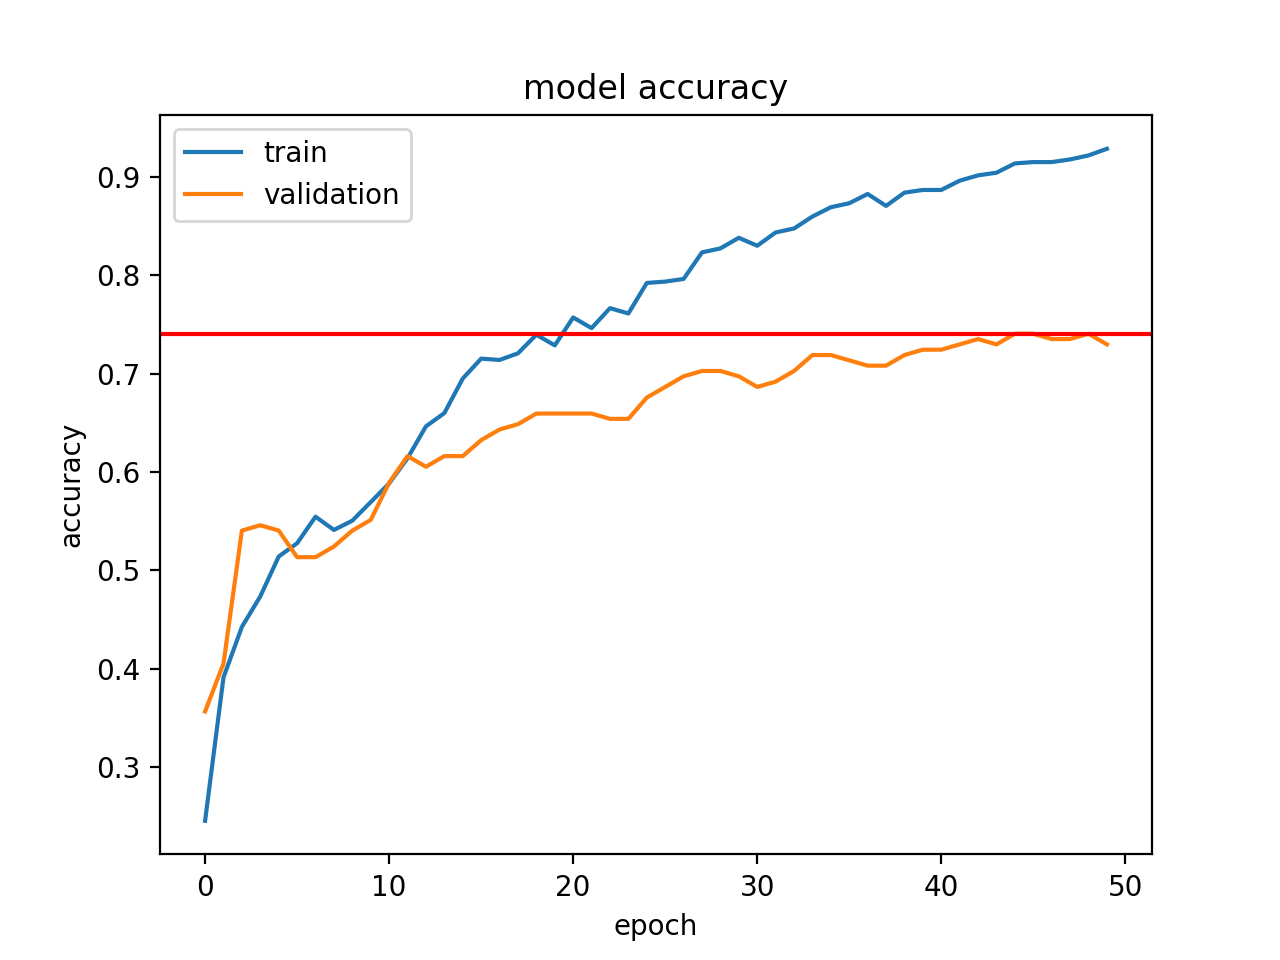

In [24]:
fold = 1

plt.rcParams['figure.figsize'] = [6, 4]

%matplotlib notebook
plt.plot(histories[fold].history['accuracy'])
plt.plot(histories[fold].history['val_accuracy'])
plt.axhline(y=0.74, color='r', linestyle='-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
print('ACCURACY')
print('cnn1 =', round(np.mean(cnn1['acc']), 3))
print('')

ACCURACY
cnn1 = 0.725



The next plot summarizes our predicted class labels relative to the true labels.

<IPython.core.display.Javascript object>


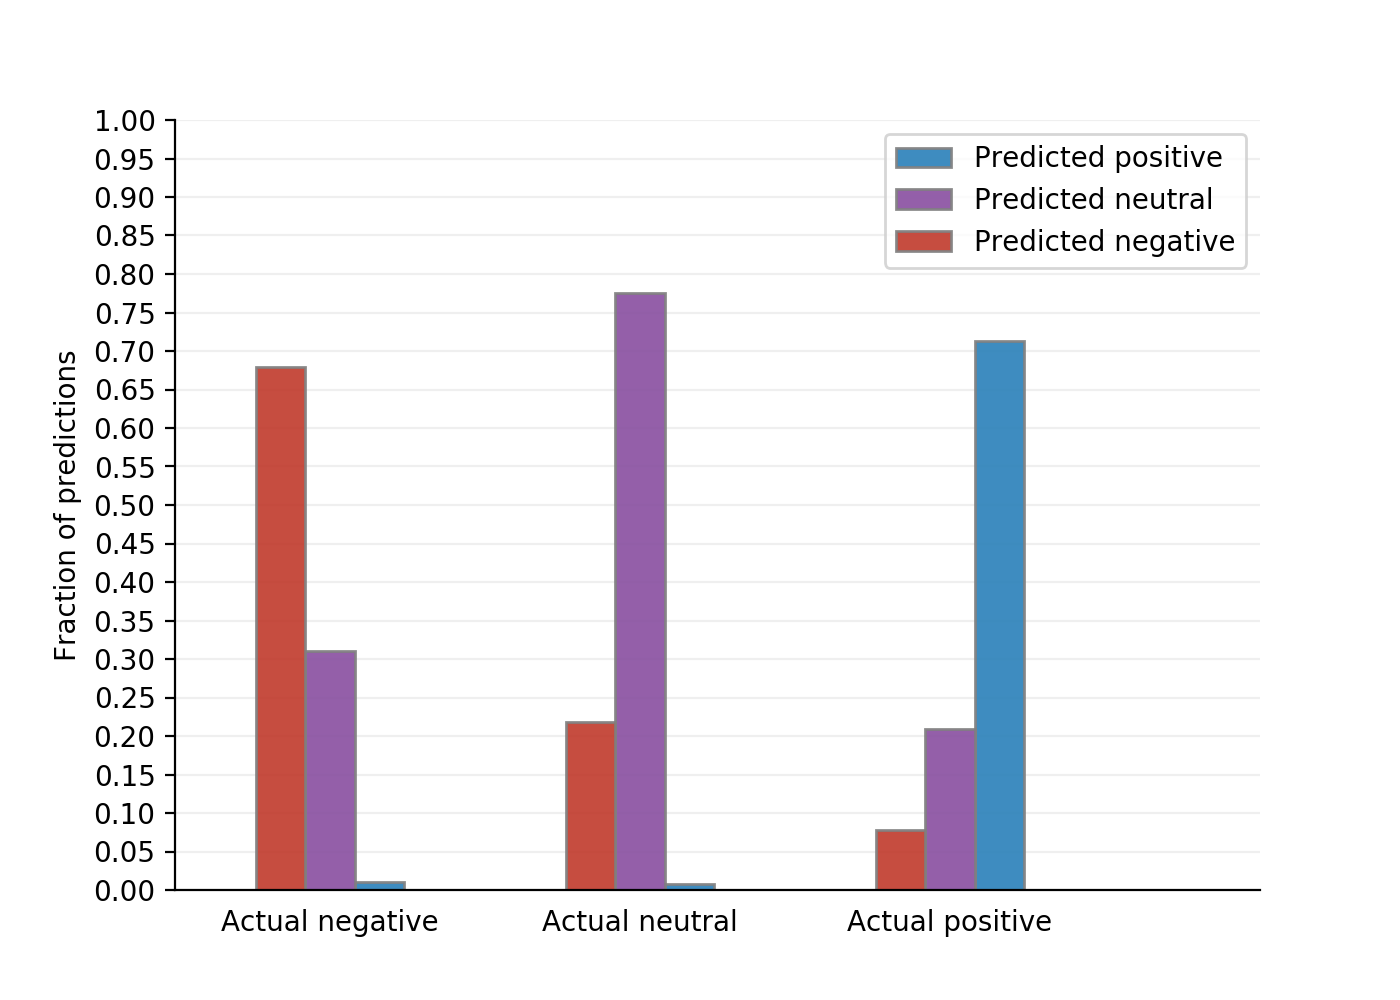

In [26]:
y_val = np.concatenate(y_val_list)
fitted = np.concatenate(fitted_list)

fitted_pos = fitted[y_val == 2]
fitted_neu = fitted[y_val == 1]
fitted_neg = fitted[y_val == 0]

metrics = ['Actual negative', 'Actual neutral', 'Actual positive']
x = np.array([1, 2, 3])
fitted_positive = [np.sum(fitted_neg == 2) / len(fitted_neg), np.sum(fitted_neu == 2) / len(fitted_neu), np.sum(fitted_pos == 2) / len(fitted_pos)]
fitted_neutral = [np.sum(fitted_neg == 1) / len(fitted_neg), np.sum(fitted_neu == 1) / len(fitted_neu), np.sum(fitted_pos == 1) / len(fitted_pos)]
fitted_negative = [np.sum(fitted_neg == 0) / len(fitted_neg), np.sum(fitted_neu == 0) / len(fitted_neu), np.sum(fitted_pos == 0) / len(fitted_pos)]
%matplotlib notebook
plt.rcParams["figure.figsize"] = (7,5)
w = 0.16
ax = plt.subplot(111)
ax.bar(x + w , fitted_positive, color='#2980B9', align='center', label='Predicted positive', width=w, edgecolor='gray', alpha=0.9)
ax.bar(x, fitted_neutral, color='#884EA0', align='center', label='Predicted neutral', width=w, edgecolor='gray', alpha=0.9)
ax.bar(x - w, fitted_negative, color='#C0392B', align='center', label='Predicted negative', width=w, edgecolor='gray', alpha=0.9)
plt.legend()
plt.xticks(x, metrics, rotation='horizontal')
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlim(0.5, 4)
plt.ylabel('Fraction of predictions')
ax.tick_params(axis="x", bottom=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(which='major', axis='y', alpha=0.2)
ax.set_axisbelow(True)
plt.show()


Since our classification problem is related to sentiment or acceptability, their may be utility in continuous metric. We can build this by getting predicted class probabilities and calculating expected sentiment based on those values and setting negative sentiment to -1, neutral to 0, and positive to 1.

The plot below summarizes our predicted values relative to the true values.

<IPython.core.display.Javascript object>


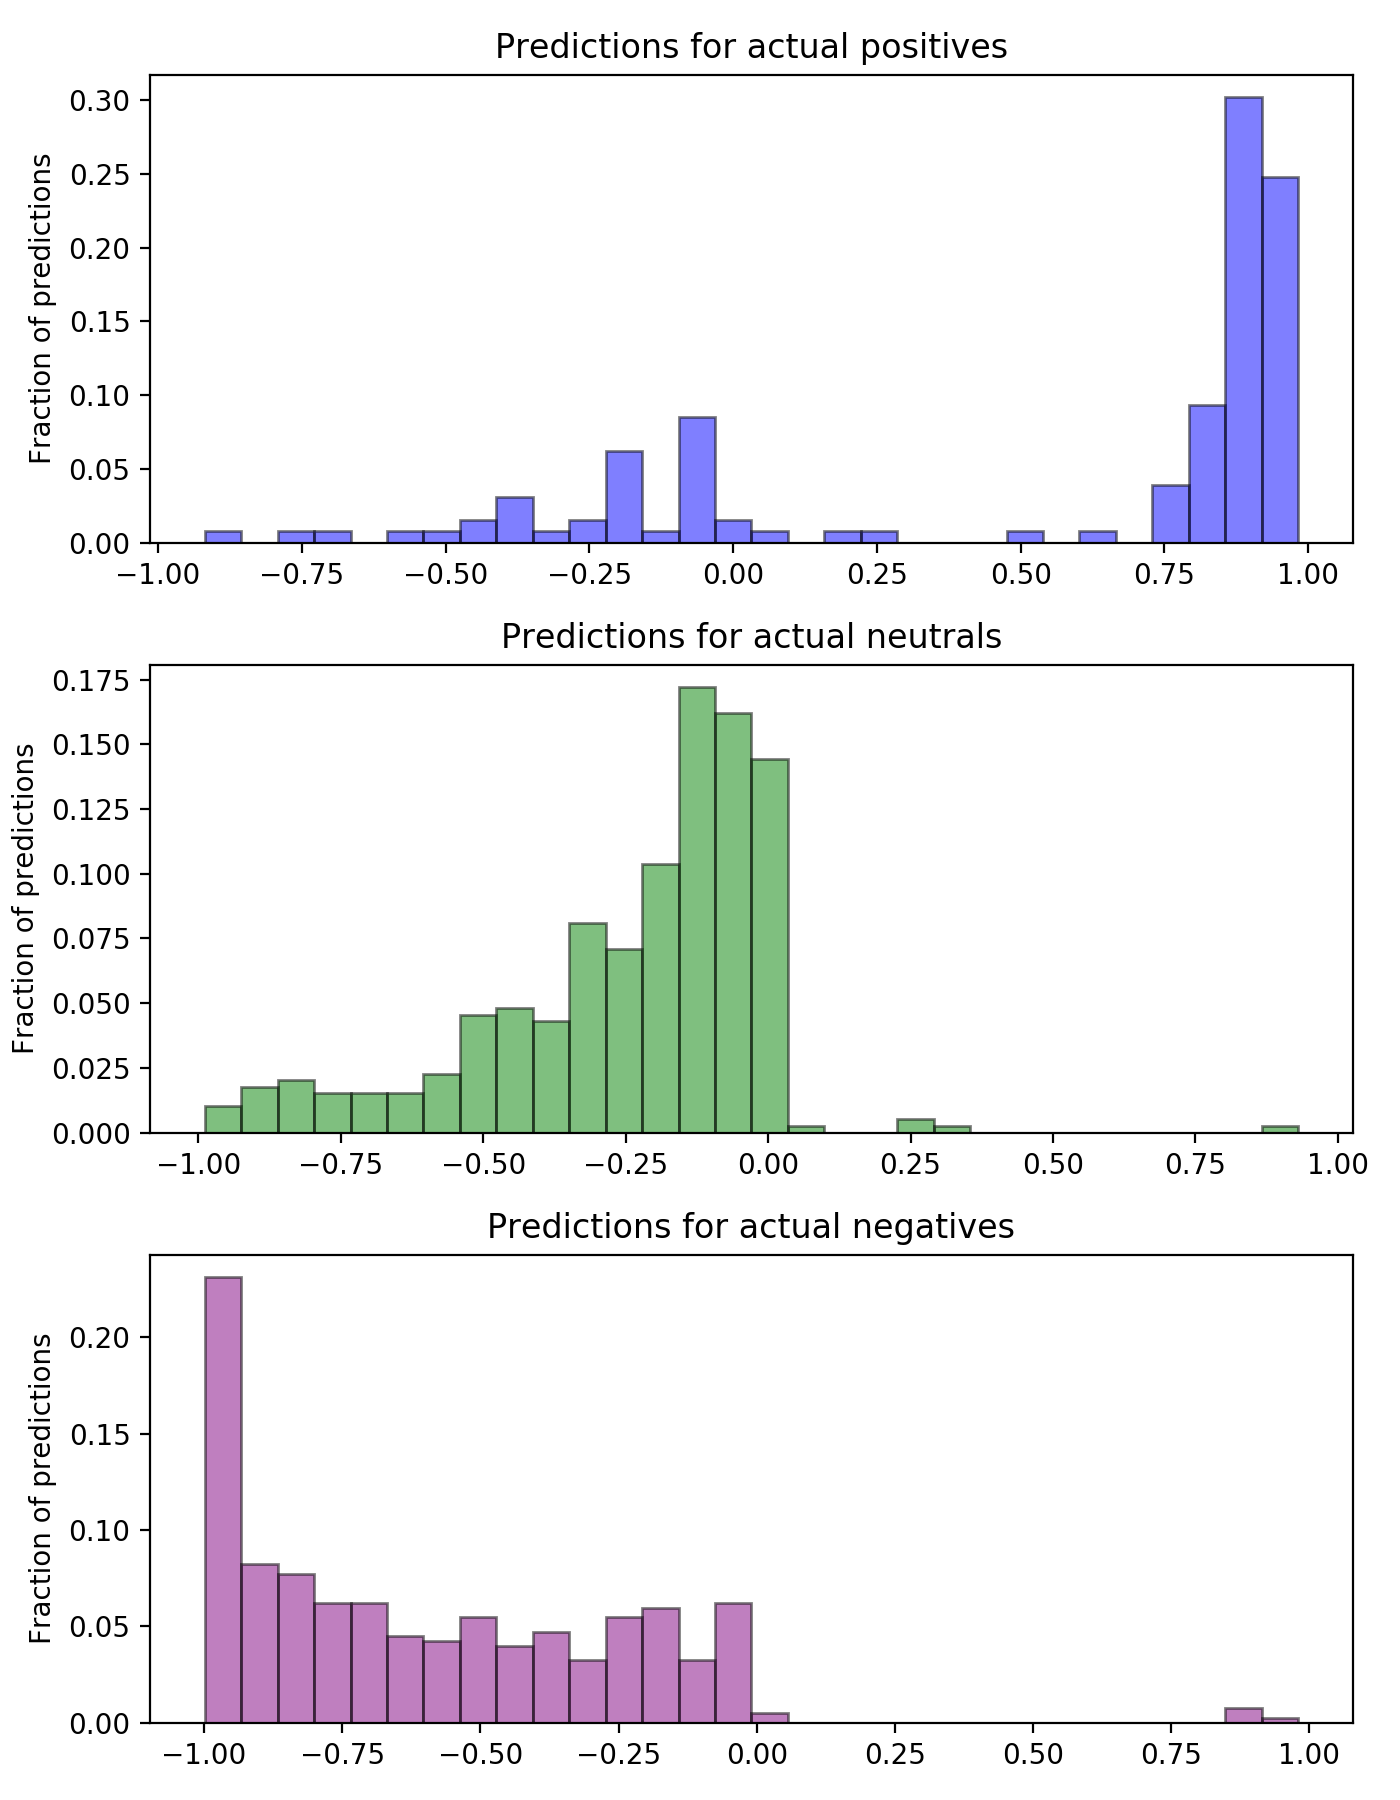

In [27]:
y_val = np.concatenate(y_val_list)
probs = np.concatenate(probs_list)

sent = np.sum(probs * np.array([-1, 0, 1]), 1)

sent_pos = sent[y_val == 2]
sent_zer = sent[y_val == 1]
sent_neg = sent[y_val == 0]

plt.rcParams['figure.figsize'] = [7, 9]

%matplotlib notebook
weights_pos = np.ones_like(sent_pos)/float(len(sent_pos))
weights_zer = np.ones_like(sent_zer)/float(len(sent_zer))
weights_neg = np.ones_like(sent_neg)/float(len(sent_neg))

fig, (ax1, ax2, ax3) = plt.subplots(3)
#fig.suptitle('Vertically stacked subplots')
ax1.hist(sent_pos, weights=weights_pos, bins=30, color='blue', edgecolor='black', alpha=0.5)
ax1.title.set_text('Predictions for actual positives')
ax1.set_ylabel('Fraction of predictions')

ax2.hist(sent_zer, weights=weights_zer, bins=30, color='green', edgecolor='black', alpha=0.5)
ax2.title.set_text('Predictions for actual neutrals')
ax2.set_ylabel('Fraction of predictions')

ax3.hist(sent_neg, weights=weights_neg, bins=30, color='purple', edgecolor='black', alpha=0.5)
ax3.title.set_text('Predictions for actual negatives')
ax3.set_ylabel('Fraction of predictions')

plt.tight_layout()
plt.show()

---

---
### 9. Train final CNN with all labeled data

We want to take the model architecture we arrived at above, and train it with all training data.

In [32]:
print(category.shape)
print(texts.shape)

(926,)
(926,)


In [31]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 300
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 32
HIDDEN_DIMS = 128
EPOCHS = 50
DROPOUT_RATE = 0.5

# our function is expecting a chunk of validation data so 
#   we'll just pass it the entire dataset as both training and validation
category_train = category
texts_train = texts
category_val = category
texts_val = texts

x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

y_val, y_train = y_to_int(category_val, category_train)

embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_google)

model, acc, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, HIDDEN_DIMS, 
                                                   EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH,
                                                   x_train, y_train, x_val, y_val, 
                                                   word_index, embedding_matrix, verbose=False)

CNN validation accuracy: 0.9211663007736206


---
### 10. Apply trained CNN to all data

In [70]:
def apply_trained_model(df, model, MAX_SEQUENCE_LENGTH, tokenizer):

    print(f'The data has {df.shape[0]} rows.')

    # convert the text col to a numpy array
    texts = np.array(df['text'])

    # convert text to the required input format
    sequences = tokenizer.texts_to_sequences(texts)
    x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # apply trained model and get predictions
    probs = model.predict(x, batch_size=BATCH_SIZE, verbose=False)
    fitted = np.argmax(probs, axis=1)
    # move from [0, 1, 2] to [-1, 0, 1]
    fitted = fitted - 1
    # get expected sentiment
    sent = np.sum(probs * np.array([-1, 0, 1]), 1)


    df['fitted_sentiment'] = fitted
    df['expected_sentiment'] = sent

    return df

In [71]:
# load the data
df1 = pd.read_csv('data_raw/results_feralswine_05012019to11042019.csv')
df2 = pd.read_csv('data_raw/results_wildpigs_05012019to11042019.csv')
df3 = pd.read_csv('data_raw/results_wildhogs_05012019to11042019.csv')

# add sentiment
df1 = apply_trained_model(df1, model, MAX_SEQUENCE_LENGTH, tokenizer)
df2 = apply_trained_model(df2, model, MAX_SEQUENCE_LENGTH, tokenizer)
df3 = apply_trained_model(df3, model, MAX_SEQUENCE_LENGTH, tokenizer)

# write to disk
df1.to_csv('data_raw/results_feralswine_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df2.to_csv('data_raw/results_wildpigs_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df3.to_csv('data_raw/results_wildhogs_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

The data has 3622 rows.
The data has 19661 rows.
The data has 25274 rows.


<IPython.core.display.Javascript object>


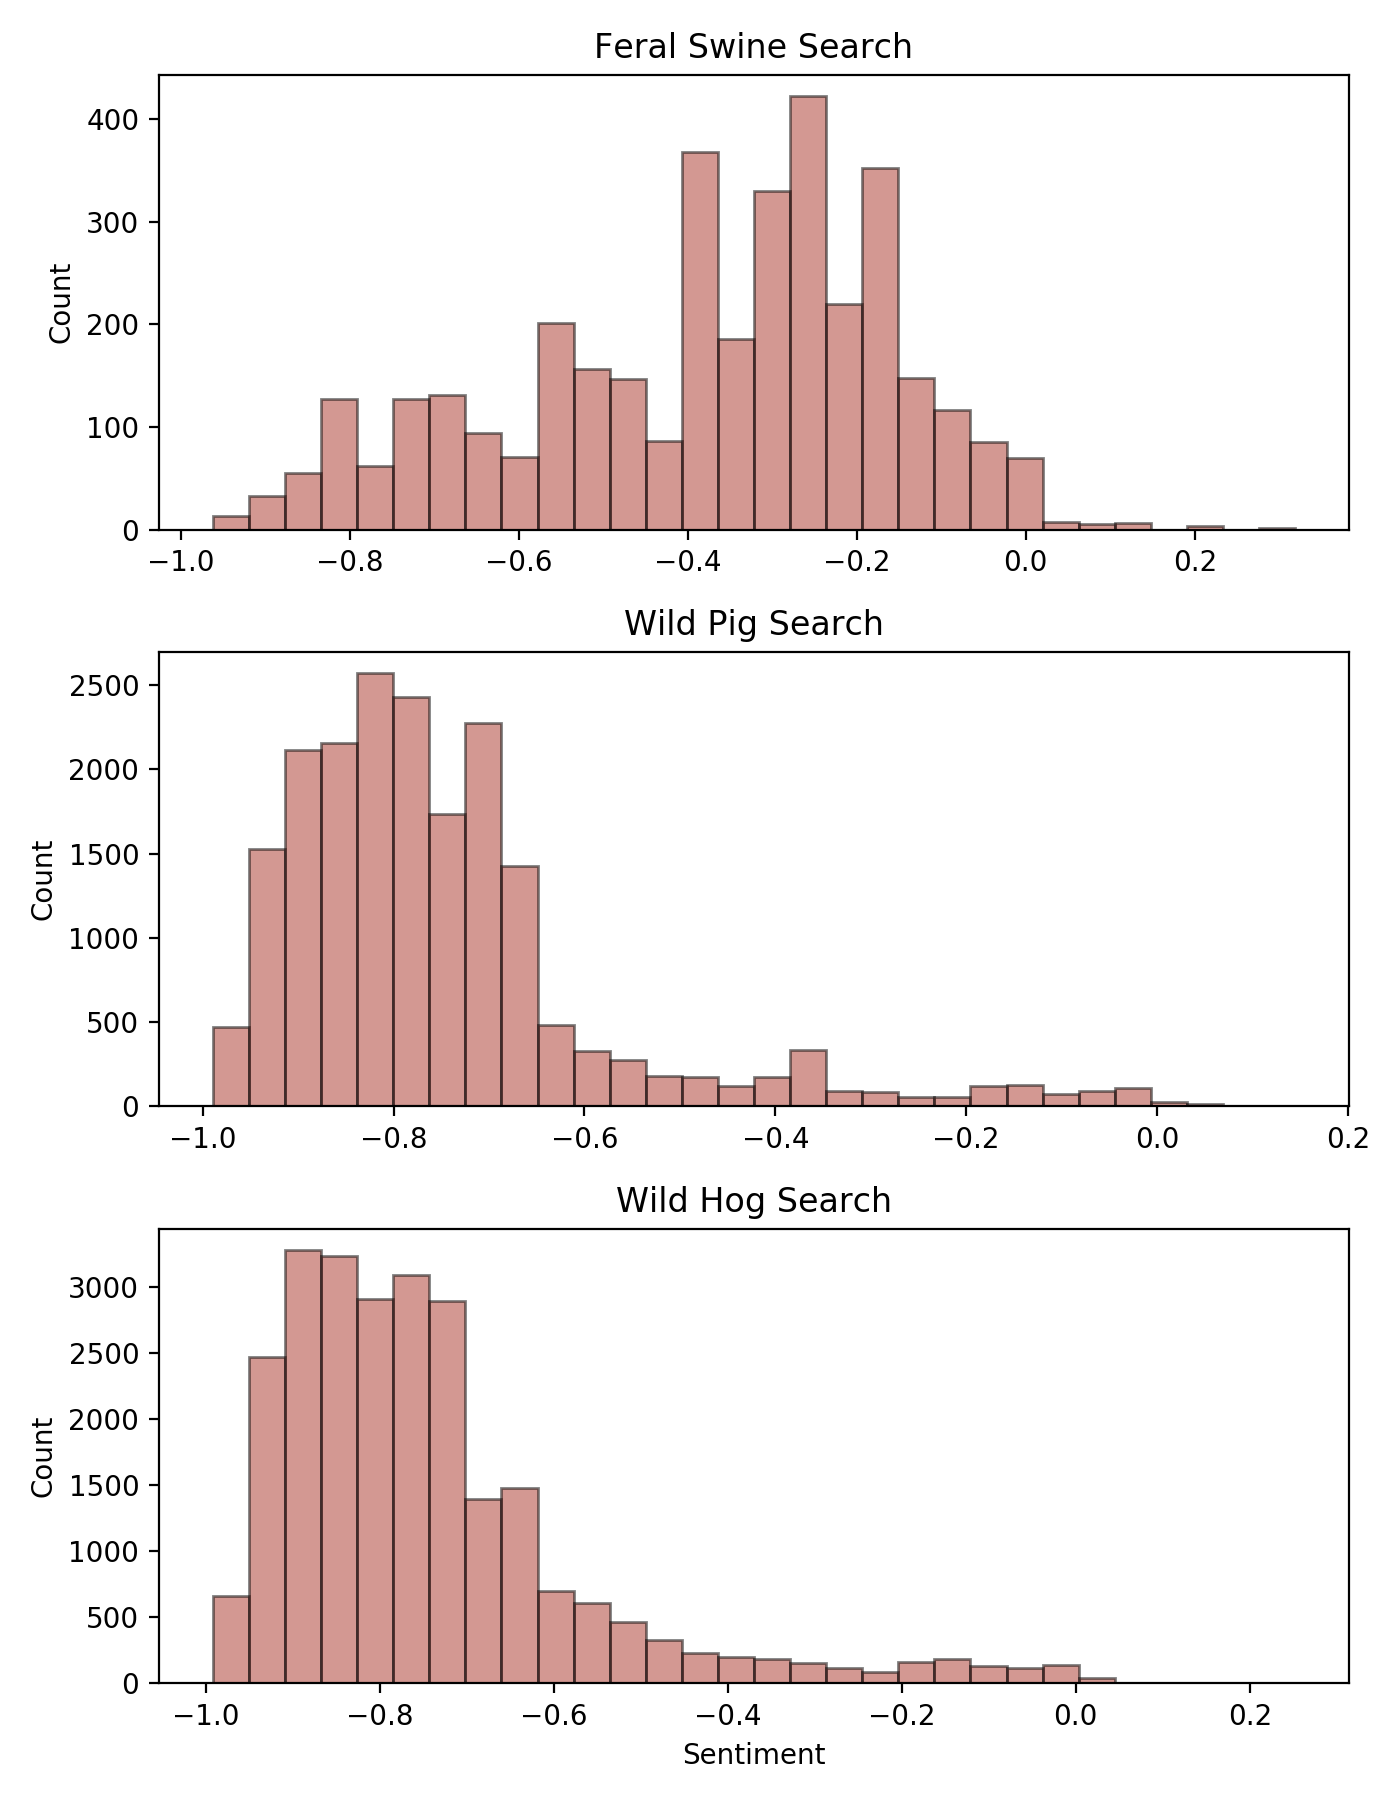

In [74]:
plt.rcParams['figure.figsize'] = [7, 9]

%matplotlib notebook

fig, (ax1, ax2, ax3) = plt.subplots(3)
#fig.suptitle('Vertically stacked subplots')
ax1.hist(df1['expected_sentiment'], bins=30, color='#A93226', edgecolor='black', alpha=0.5)
ax1.title.set_text('Feral Swine Search')
ax1.set_ylabel('Count')

ax2.hist(df2['expected_sentiment'], bins=30, color='#A93226', edgecolor='black', alpha=0.5)
ax2.title.set_text('Wild Pig Search')
ax2.set_ylabel('Count')

ax3.hist(df3['expected_sentiment'], bins=30, color='#A93226', edgecolor='black', alpha=0.5)
ax3.title.set_text('Wild Hog Search')
ax3.set_ylabel('Count')
ax3.set_xlabel('Sentiment')

plt.tight_layout()
plt.show()

---